In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm

# Add the directory containing `pokie.py` to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))

# Import pokie from pokie.py
from pokie import pokie

# Sample from GMM

In [2]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 2 Dimension

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 63.24it/s]


Final Models Shape: (21, 500, 500, 2)
Truth Data Shape: (500, 2)
Shape validation passed!
Truth Data Normalized:
Min: [0. 0.]
Max: [1. 1.]

Models Normalized (Overall):
Min: -0.8583905408365634
Max: 1.843180011056796

Model 0 (Shift -10):
Min: -0.8583905408365634
Max: 0.21682873094261781

Model 1 (Shift -9):
Min: -0.8024775315188436
Max: 0.27968874801813143

Model 2 (Shift -8):
Min: -0.7585380845037669
Max: 0.3491078115926412

Model 3 (Shift -7):
Min: -0.6476071852043103
Max: 0.4208259824472008

Model 4 (Shift -6):
Min: -0.5872874367093078
Max: 0.531295783986765

Model 5 (Shift -5):
Min: -0.4849607747758585
Max: 0.5901682778165476

Model 6 (Shift -4):
Min: -0.35362336759900126
Max: 0.7696524564492232

Model 7 (Shift -3):
Min: -0.3244706347568342
Max: 0.7982500933021477

Model 8 (Shift -2):
Min: -0.160674826708288
Max: 0.8390066999726832

Model 9 (Shift -1):
Min: -0.11957259715880604
Max: 0.8976491417696119

Model 10 (Shift 0):
Min: 0.0004202525784944735
Max: 1.0319138054644017

Model 1

100%|██████████| 100/100 [00:22<00:00,  4.51it/s]

Shape of total_probability: (100, 21)
Results: [0.04202624 0.04302805 0.04417754 0.0453251  0.04698265 0.04873008
 0.04975251 0.05110667 0.05188132 0.05235079 0.05306054 0.05231683
 0.05199707 0.05081335 0.04951411 0.04741272 0.04603609 0.04521064
 0.04361957 0.04278793 0.0418702 ]
Best Model Index: 10


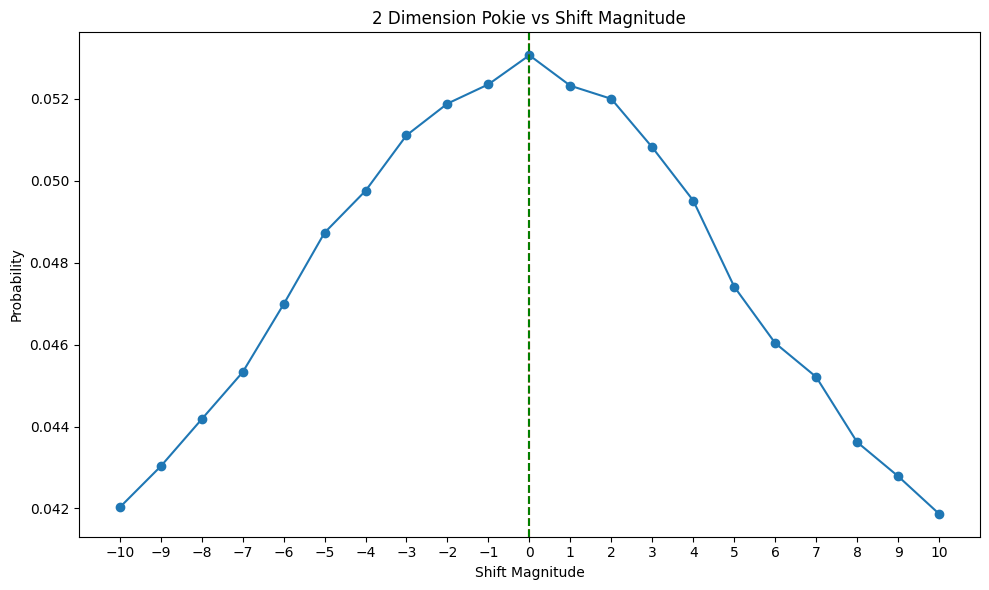

In [3]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 2
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

print(f'Final Models Shape: {models.shape}')  # Expected: (21, 500, 500, 2)
print(f'Truth Data Shape: {truth_data.shape}')  # Expected: (500, 2)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"
print("Shape validation passed!")


epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

# Check min and max of the normalized truth data
print("Truth Data Normalized:")
print("Min:", np.min(truth_data_normalized, axis=0))
print("Max:", np.max(truth_data_normalized, axis=0))

# Check min and max across all models
print("\nModels Normalized (Overall):")
print("Min:", np.min(models_normalized))
print("Max:", np.max(models_normalized))

# Check min and max for each model separately
for m_idx, shift_val in enumerate(shift_magnitudes):
    print(f"\nModel {m_idx} (Shift {shift_val}):")
    print("Min:", np.min(models_normalized[m_idx]))
    print("Max:", np.max(models_normalized[m_idx]))

results = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('Results:', results)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('2 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.show()

In [4]:
models_normalized[0].shape

(500, 500, 2)

100%|██████████| 100/100 [00:01<00:00, 84.54it/s]


Individual Model Results: [array([0.53225721]), array([0.54273709]), array([0.55879457]), array([0.57322655]), array([0.59295641]), array([0.61142667]), array([0.62591042]), array([0.64221461]), array([0.65240707]), array([0.65779118]), array([0.66772483]), array([0.66040244]), array([0.654041]), array([0.63934966]), array([0.62295325]), array([0.5973123]), array([0.58113892]), array([0.5721196]), array([0.54866567]), array([0.54184858]), array([0.52831776])]
Best Model Index: 10


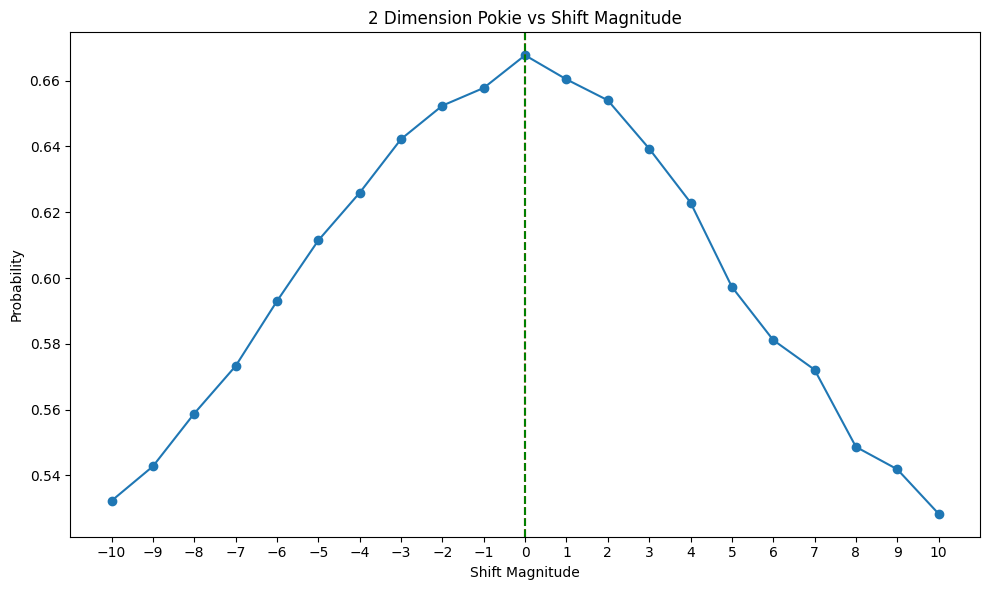

In [5]:
# Loop through GMM models & pass it to pokie and plot the results
results = []
for i in range(num_models):
    curr_model = models_normalized[i]
    # Reshape (500, 500, 2) to (1, 500, 500, 2)
    curr_model = curr_model[np.newaxis, :, :, :]
    curr_results = pokie(truth_data_normalized, curr_model, num_runs = 100)
    results.append(curr_results)

print(f'Individual Model Results: {results}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('2 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.show()

# 20 Dimension

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 74.28it/s]


Final Models Shape: (21, 500, 500, 10)
Truth Data Shape: (500, 10)
Shape validation passed!
Truth Data Normalized:
Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Models Normalized (Overall):
Min: -1.0298305836516457
Max: 2.109471790125149

Model 0 (Shift -10):
Min: -1.0298305836516457
Max: 0.22707677845787774

Model 1 (Shift -9):
Min: -0.9181145779436668
Max: 0.3131638448303878

Model 2 (Shift -8):
Min: -0.8484777031681437
Max: 0.4319400371418294

Model 3 (Shift -7):
Min: -0.7333616715124132
Max: 0.4856161425371434

Model 4 (Shift -6):
Min: -0.6196935327083836
Max: 0.6231000432800303

Model 5 (Shift -5):
Min: -0.5216583765977606
Max: 0.7011480723600275

Model 6 (Shift -4):
Min: -0.4500831929469022
Max: 0.7136753795425346

Model 7 (Shift -3):
Min: -0.3754795885928089
Max: 0.7935490123641651

Model 8 (Shift -2):
Min: -0.22312947821831516
Max: 0.8887473673186079

Model 9 (Shift -1):
Min: -0.1639265446819812
Max: 0.9963720314494343

Model 10 (Shift 0):
Min: -0.0

100%|██████████| 100/100 [00:27<00:00,  3.57it/s]

Shape of total_probability: (100, 21)
Results: [0.04253828 0.04252669 0.04272788 0.04284987 0.04345409 0.04504007
 0.04774326 0.05149938 0.05459363 0.05627167 0.05677407 0.05629179
 0.05515309 0.05221897 0.04855275 0.04614936 0.04422519 0.04332341
 0.04273651 0.04256788 0.04276218]
Best Model Index: 10


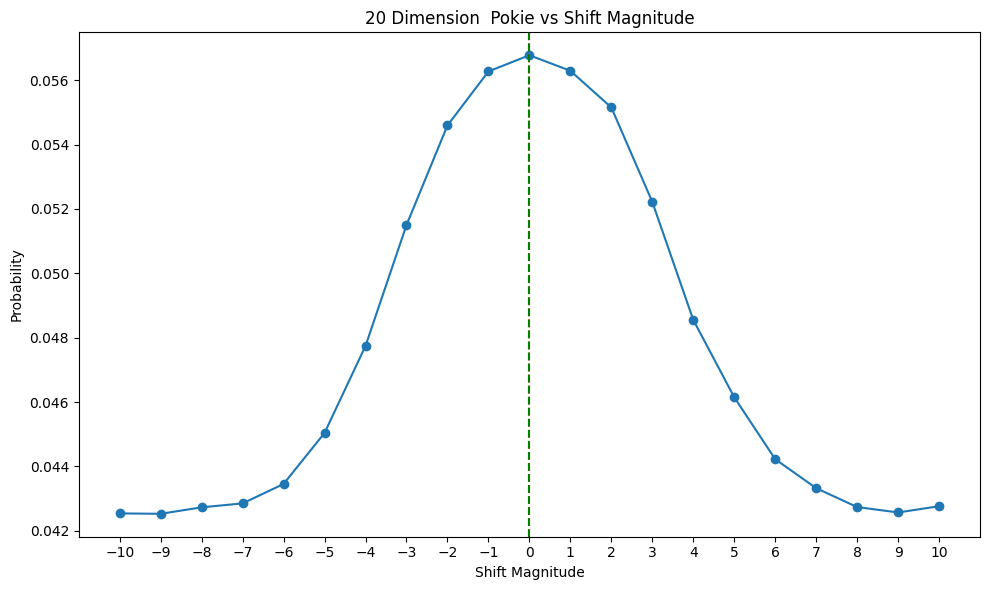

In [6]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 10
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

print(f'Final Models Shape: {models.shape}')  # Expected: (21, 500, 500, 2)
print(f'Truth Data Shape: {truth_data.shape}')  # Expected: (500, 2)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"
print("Shape validation passed!")


epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

# Check min and max of the normalized truth data
print("Truth Data Normalized:")
print("Min:", np.min(truth_data_normalized, axis=0))
print("Max:", np.max(truth_data_normalized, axis=0))

# Check min and max across all models
print("\nModels Normalized (Overall):")
print("Min:", np.min(models_normalized))
print("Max:", np.max(models_normalized))

# Check min and max for each model separately
for m_idx, shift_val in enumerate(shift_magnitudes):
    print(f"\nModel {m_idx} (Shift {shift_val}):")
    print("Min:", np.min(models_normalized[m_idx]))
    print("Max:", np.max(models_normalized[m_idx]))

results = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('Results:', results)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('20 Dimension  Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:01<00:00, 67.76it/s]


Individual Model Results: [array([0.50103593]), array([0.50010044]), array([0.50004699]), array([0.50168156]), array([0.50944475]), array([0.5268501]), array([0.5596784]), array([0.60119433]), array([0.64064531]), array([0.66134068]), array([0.66801836]), array([0.6609895]), array([0.64927729]), array([0.61458048]), array([0.57145242]), array([0.54222563]), array([0.51977852]), array([0.5073998]), array([0.50465257]), array([0.50039948]), array([0.50254527])]
Best Model Index: 10


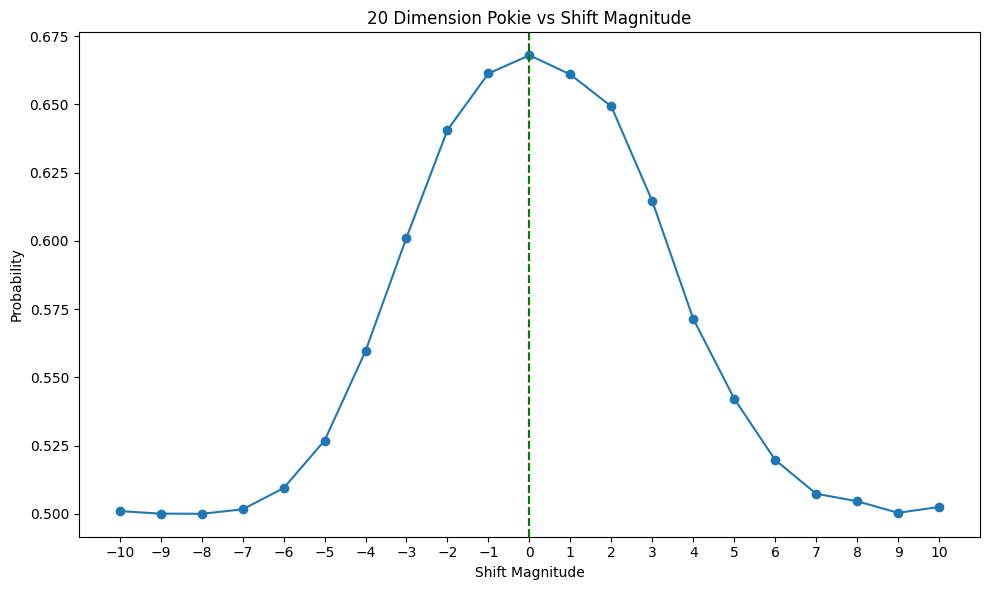

In [7]:
# Loop through GMM models & pass it to pokie and plot the results
results = []
for i in range(num_models):
    curr_model = models_normalized[i]
    # Reshape (500, 500, 2) to (1, 500, 500, 2)
    curr_model = curr_model[np.newaxis, :, :, :]
    curr_results = pokie(truth_data_normalized, curr_model, num_runs = 100)
    results.append(curr_results)

print(f'Individual Model Results: {results}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('20 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.show()

# 100 Dimension

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:07<00:00,  2.79it/s]


Final Models Shape: (21, 500, 500, 100)
Truth Data Shape: (500, 100)
Shape validation passed!
Truth Data Normalized:
Min: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Max: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]

Models Normalized (Overall):
Min: -1.0374253396320445
Max: 2.0115497774323576

Model 0 (Shift -10):
Min: -1.0374253396320445
Max: 0.36598444272239355

Model 1 (Shift -9):
Min: -0.9523719864977975
Max: 0.4238352903439534

Model 2 (Shift -8):
Min: -0.86820133355

100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


Shape of total_probability: (100, 21)
Results: [0.04474312 0.04474551 0.04480033 0.04471549 0.04481086 0.044722
 0.04487184 0.04594297 0.05267657 0.05868921 0.05984347 0.05867337
 0.05159675 0.04587085 0.04482443 0.04464339 0.04478849 0.04479656
 0.04469141 0.04480406 0.04474932]
Best Model Index: 10


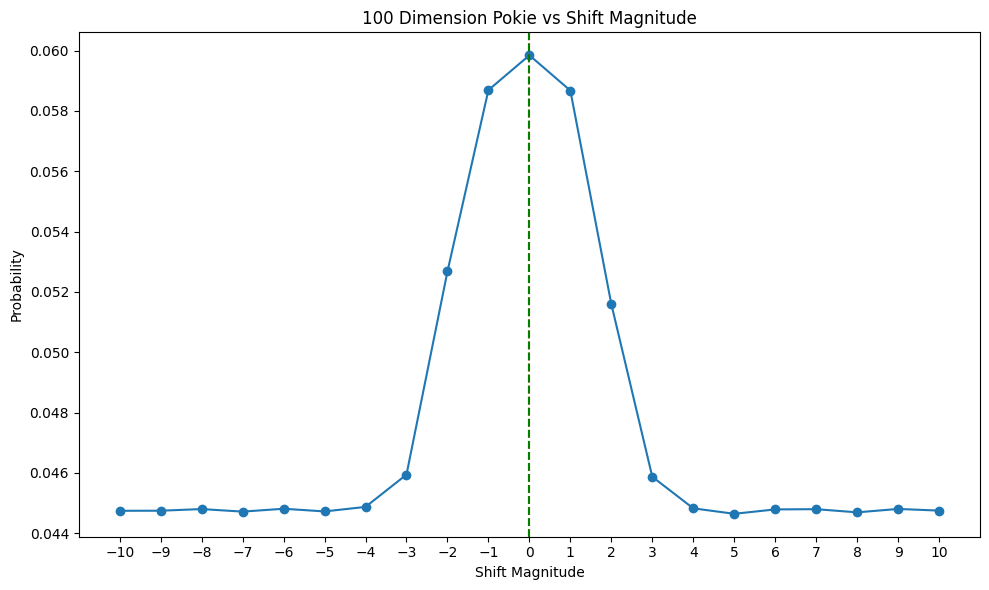

In [8]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 100
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

print(f'Final Models Shape: {models.shape}')  # Expected: (21, 500, 500, 2)
print(f'Truth Data Shape: {truth_data.shape}')  # Expected: (500, 2)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"
print("Shape validation passed!")


epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

# Check min and max of the normalized truth data
print("Truth Data Normalized:")
print("Min:", np.min(truth_data_normalized, axis=0))
print("Max:", np.max(truth_data_normalized, axis=0))

# Check min and max across all models
print("\nModels Normalized (Overall):")
print("Min:", np.min(models_normalized))
print("Max:", np.max(models_normalized))

# Check min and max for each model separately
for m_idx, shift_val in enumerate(shift_magnitudes):
    print(f"\nModel {m_idx} (Shift {shift_val}):")
    print("Min:", np.min(models_normalized[m_idx]))
    print("Max:", np.max(models_normalized[m_idx]))

results = pokie(truth_data_normalized, models_normalized, num_runs = 100)
print('Results:', results)

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('100 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:04<00:00, 22.46it/s]


Individual Model Results: [array([0.49927465]), array([0.50121577]), array([0.49864092]), array([0.5013519]), array([0.50268627]), array([0.50041621]), array([0.49987896]), array([0.51379078]), array([0.58669541]), array([0.65316475]), array([0.66571473]), array([0.65510699]), array([0.57541657]), array([0.50693505]), array([0.50095381]), array([0.50077848]), array([0.49837525]), array([0.49868874]), array([0.50173006]), array([0.50010363]), array([0.50206152])]
Best Model Index: 10


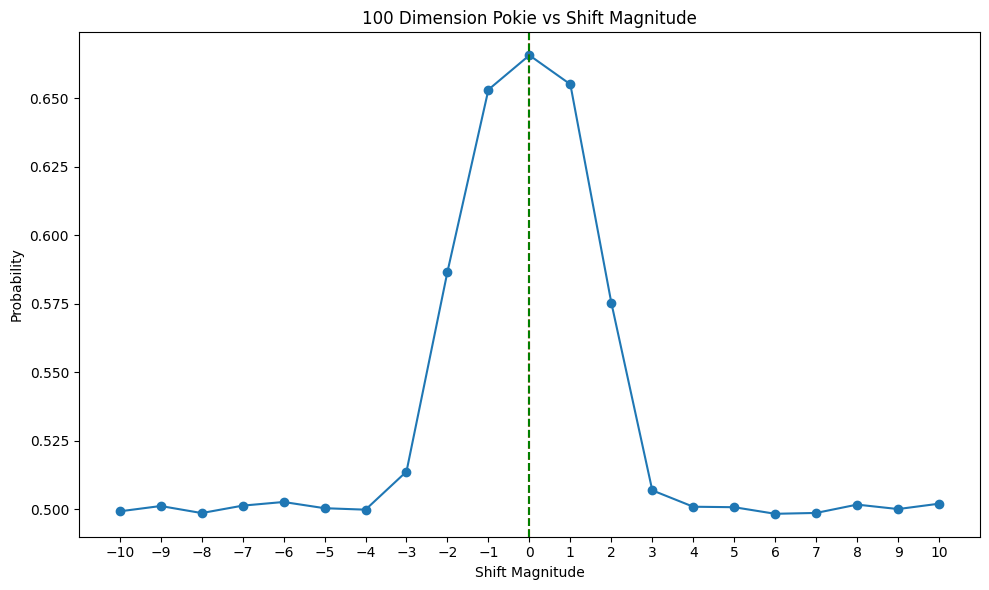

In [9]:
# Loop through GMM models & pass it to pokie and plot the results
results = []
for i in range(num_models):
    curr_model = models_normalized[i]
    # Reshape (500, 500, 2) to (1, 500, 500, 2)
    curr_model = curr_model[np.newaxis, :, :, :]
    curr_results = pokie(truth_data_normalized, curr_model, num_runs = 100)
    results.append(curr_results)

print(f'Individual Model Results: {results}')

# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

print('Best Model Index:', best_model_idx)
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.xlabel('Shift Magnitude')
# plt.ylabel(r'$P_{\text{Pokie}}$')
plt.ylabel('Probability')
plt.title('100 Dimension Pokie vs Shift Magnitude')
plt.xticks(shift_magnitudes)
# Vertical line at shift magnitude of 0 (no shift)
plt.axvline(x=0, color='r', linestyle='--')
# Find the best model and plot a vertical line at its shift magnitude
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--')
plt.tight_layout()
plt.show()